# Task 2: Recommendation Engine - Skeleton Notebook

This notebook provides a very basic example for the notebook you are expected to submit for Task 2 of the Final Project. The main purpose is that we can try different examples to get a better sense of your approach. Compared to Task 1 (Kaggle Competition), we don't have any objective means to evaluate the recommendations. 

Some general comments:
* You can import any data you need. This particularly includes your cleaned version of the properties dataset (incl. the auxiliary data or any other data you might have collected); there's no need to show the data cleaning / preprocessing steps in this notebook.
* You can also import your code in form of external Python (.py) script. You're actually encouraged to do so to keep this notebook light and uncluttered.
* **Important:** Please consider this notebook as an example and not to set specific requirements. Your notebook is likely to look very different. As long there is a section where we can easily test your solution, it should be fine.

## Setting up the Notebook

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pathlib import Path



## Load the Data

For this example, we use a simplified version of the dataset with only 2k+ data samples, each with only a subset of features.

In [3]:
df_sample = pd.read_csv('data/sg-property-prices-simplified.csv')

df_sample.head()

,listing_id,title,property_name,property_type,built_year,num_beds,num_baths,size_sqft,planning_area,price
0,799762,hdb flat for sale in 524 ang mo kio avenue 5,hdb-ang mo kio,hdb 3 rooms,1980.0,2.0,2.0,732,ang mo kio,419000.0
1,896907,4 bed condo for sale in kopar at newton,kopar at newton,condo,2023.0,4.0,4.0,1528,novena,3727500.0
2,445021,4 bed condo for sale in nouvel 18,nouvel 18,condo,2014.0,4.0,3.0,2476,newton,8013600.0
3,252293,hdb flat for sale in 467 jurong west street 41,hong kah ville,hdb,1985.0,3.0,2.0,1302,jurong west,682500.0
4,926453,hdb flat for sale in 664b punggol drive,waterway sunbeam,Hdb 5 Rooms,2016.0,3.0,2.0,1184,punggol,764400.0


In [5]:
df_train = pd.read_csv("../../../clean_data/train_preproc.csv", index_col=0)
df_train

,num_beds,num_baths,size_sqft,total_num_units,lat,lng,price,active_years,planning_area_density,remaining_lease,...,mean_property_sqft,mean_planning_sqft,planning_area_mean,total_rooms,size_per_room,mean_property_type,distance,num_shopping_malls,tenure_99-year leasehold,tenure_freehold
0,3.0,2.0,1115,116.00000,1.414399,103.837196,514500.0,34.000000,15290.636281,65.000000,...,1063.446642,1244.961765,1.148675e+06,5.0,223.000000,6.595184e+05,0.573567,2.000000,1,0
1,4.0,2.0,1575,375.36085,1.372597,103.875625,995400.0,30.000000,12981.843721,69.000000,...,1063.446642,2582.707317,3.799670e+06,6.0,262.500000,6.595184e+05,1.728895,3.000000,1,0
2,4.0,6.0,3070,56.00000,1.298773,103.895798,8485000.0,0.000000,7535.378473,999.000000,...,1179.143997,1806.595166,3.889591e+06,10.0,307.000000,2.966084e+06,1.315256,5.000000,0,1
3,3.0,2.0,958,638.00000,1.312364,103.803271,2626000.0,-1.000000,5513.897301,1000.000000,...,1179.143997,2568.777256,5.952523e+06,5.0,191.600000,2.966084e+06,0.723885,4.000000,0,1
4,2.0,1.0,732,351.00000,1.273959,103.843635,1764000.0,-4.000000,920.930181,103.000000,...,1179.143997,1650.031397,4.988207e+06,3.0,244.000000,2.966084e+06,0.370022,16.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17390,5.0,6.0,4973,375.36085,1.321145,103.813679,12999000.0,2.809524,3059.089440,996.190476,...,4046.952586,1425.035036,5.018539e+06,11.0,452.090909,6.227098e+06,0.234406,4.896748,0,1
17391,2.0,2.0,635,605.00000,1.385938,103.834466,1050000.0,-4.000000,16124.059033,103.000000,...,1179.143997,1659.301711,2.375807e+06,4.0,158.750000,2.966084e+06,0.150007,4.000000,1,0
17392,2.0,2.0,883,137.00000,1.315948,103.857589,2087400.0,-4.000000,15146.559431,1003.000000,...,1179.143997,1108.390909,2.205680e+06,4.0,220.750000,2.966084e+06,0.442631,6.000000,0,1
17393,3.0,2.0,1205,402.00000,1.440753,103.806671,754800.0,5.000000,16490.441156,94.000000,...,1063.446642,1228.185059,8.077212e+05,5.0,241.000000,6.595184e+05,0.632423,8.000000,1,0


## Computing the Top Recommendations

The method `get_top_recommendations()` shows an example of how to get the top recommendations for a given data sample (data sample = row in the dataframe of the dataset). The input is a row from the dataset and a list of optional input parameters which will depend on your approach; `k` is the number of returned recommendations seems useful, though.

The output should be a `pd.DataFrame` containing the recommendations. The output dataframe should have the same columns as the row + any additional columns you deem important (e.g., any score or tags that you might want to add to your recommendations).

In principle, the method `get_top_recommendations()` may be imported from a external Python (.py) script as well.

In [14]:
df_train_simple=df_train[['lat','lng']]

In [16]:
def cluster_plot(data, nclusters):
    X = data.copy()
    cols = list(X.columns)
    km = KMeans(n_clusters=nclusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)


    # Visualize it:
    plt.figure(figsize=(15, 12))
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=km.labels_.astype(float))

    # plot the centroids
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', label='centroids')
    plt.xlabel(cols[0])
    plt.ylabel(cols[1])
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.show()

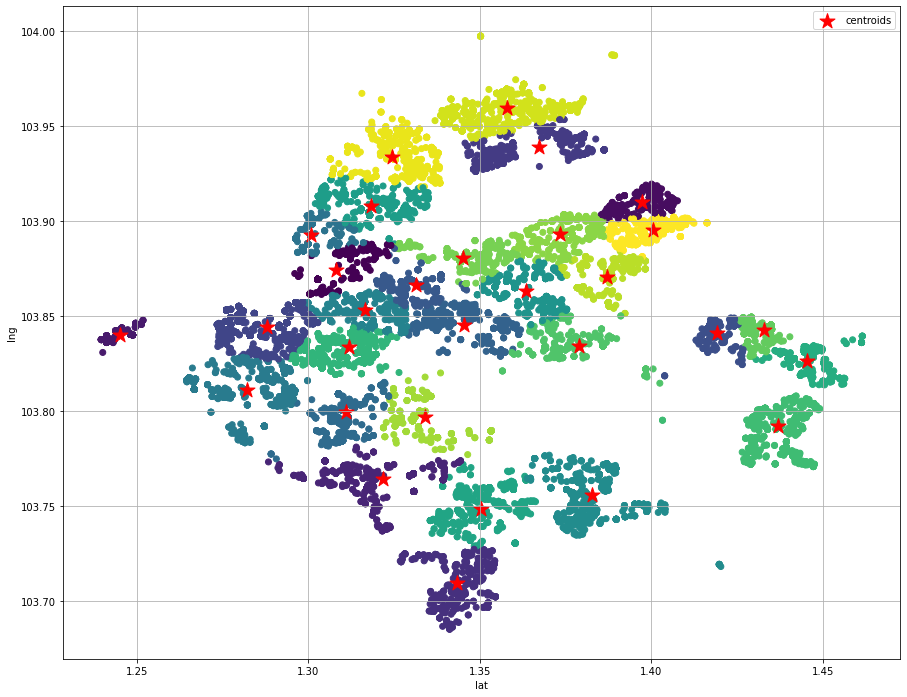

In [18]:
cluster_plot(df_train_simple,30)

In [25]:

score = []
for k in range(2,50):
    kmeans = KMeans(n_clusters=k,random_state=4)
    kmeans.fit(df_train_simple)
    labels = kmeans.labels_
    ss = silhouette_score(df_train_simple,labels)
    score.append(ss)

Text(0.5, 0, 'no of clusters')

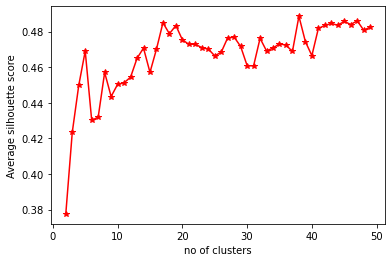

In [26]:
plt.plot(range(2,50), score, marker='*',color='r')
plt.ylabel('Average silhouette score')
plt.xlabel('no of clusters')

In [ ]:
# plt.figure(figsize=(15,5))
# sns.scatterplot(y=df_train['long'],x=df_train['lat'],hue=d1['cluster'],palette='deep')

In [3]:
def get_top_recommendations(row, **kwargs) -> pd.DataFrame:
    
    #####################################################
    ## Initialize the required parameters
    
    # The number of recommendations seem recommended
    # Additional input parameters are up to you
    k = None
    
    # Extract all **kwargs input parameters
    # and set the used paramaters (here: k)
    for key, value in kwargs.items():
        if key == 'k':
            k = value
            
       
    #####################################################
    ## Compute your recommendations
    #
    # This is where your magic happens. Of course, you can call methods
    # defined in this notebook or in external Python (.py) scripts
    #
        
    # Here, we just return the input row k times
    # Ideally, you recommendations will be much better
    df_result = pd.DataFrame([row] * k, index=None)
        
    # Return the dataset with the k recommendations
    return df_result


## Testing the Recommendation Engine

This will be the main part of your notebook to allow for testing your solutions. Most basically, for a given listing (defined by the row id in your input dataframe), we would like to see the recommendations you make. So however you set up your notebook, it should have at least a comparable section that will allow us to run your solution for different inputs.

### Pick a Sample Listing as Input

In [4]:
# Pick a row id of choice
row_id = 10
#row_id = 20
#row_id = 30
#row_id = 40
#row_id = 50

# Get the row from the dataframe (an valid row ids will throw an error)
row = df_sample.iloc[row_id]

# Just for printing it nicely, we create a new dataframe from this single row
pd.DataFrame([row])

,listing_id,title,property_name,property_type,built_year,num_beds,num_baths,size_sqft,planning_area,price
10,954673,5 bed house for sale in pasir ris beach park,pasir ris beach park,bungalow,1977.0,5.0,6.0,7534,pasir ris,9030000.0


## Compute and Display the recommendations

Since the method `get_top_recommendations()` returns a `pd.DataFrame`, it's easy to display the result.

In [5]:
k = 3

df_recommendations = get_top_recommendations(row, k=k)

df_recommendations.head(k)

,listing_id,title,property_name,property_type,built_year,num_beds,num_baths,size_sqft,planning_area,price
10,954673,5 bed house for sale in pasir ris beach park,pasir ris beach park,bungalow,1977.0,5.0,6.0,7534,pasir ris,9030000.0
10,954673,5 bed house for sale in pasir ris beach park,pasir ris beach park,bungalow,1977.0,5.0,6.0,7534,pasir ris,9030000.0
10,954673,5 bed house for sale in pasir ris beach park,pasir ris beach park,bungalow,1977.0,5.0,6.0,7534,pasir ris,9030000.0
